Testing the script in "OBE_integrator.py" to make sure it gives the same results as the earlier notebooks

In [1]:
#Import packages
%load_ext autoreload
%autoreload 2
import sys
import numpy as np
sys.path.append('./molecular-state-classes-and-functions/')
from classes import UncoupledBasisState, CoupledBasisState, State
from functions import ni_range
from OBE_functions import calculate_power_needed, multipassed_laser_E_field

import matplotlib.pyplot as plt
%matplotlib notebook

#Import classes for defining laser and microwave fields
from OBE_classes import OpticalField, MicrowaveField

#Import the OBE integrator script
from OBE_integrator import OBE_integrator

## X-state

In [2]:
#Define what states are to be included in the simulation
Js_g = [0,1,2,3]
I_F = 1/2
I_Tl = 1/2
ground_states_approx = [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
                  for J  in Js_g
                  for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
                  for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
                  for mF in ni_range(-F, F+1)
                 ]

## B-state

In [3]:
#Define what states are to be included in the simulation
J = 1
F1 = 3/2
F = 1
excited_states_approx = [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='B', P = -1, Omega = 1)
                  for mF in ni_range(-F, F+1)
                 ]

In [9]:
Gamma = 2*np.pi*1.6e6

## Laser field

In [10]:
#Define ground states for laser driven transition
Js = [2]
ground_states_laser_approx =  [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
                                  for J  in Js
                                  for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
                                  for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
                                  for mF in ni_range(-F, F+1)
                                 ]

#Define excited states for laser
excited_states_laser_approx = excited_states_approx

In [11]:
ground_main_approx = 1*CoupledBasisState(J=2,F1=5/2,F=2,mF=0,I1=1/2,I2=1/2,electronic_state='X', P = 1, Omega = 0)
excited_main_approx = 1*CoupledBasisState(J = 1,F1=3/2,F=1,mF=0,I1=1/2,I2=1/2, electronic_state='B', P = -1, Omega = 1)

In [12]:
#Polarization as function of time
omega_p = .25*Gamma
beta = 0
omega_sb = 2*np.pi*1.6e6
p_t = lambda t: np.array([np.sin(omega_p*t), 0, np.cos(omega_p*t)]) * np.exp(1j*beta*np.sin(omega_sb*t))


#Generate a spatial profile for the Rabi rate
Omega = 2*np.pi*1e6
fwhm_z = 1e-3
fwhm_y = 5e-3
E_peak = Omega
laser_power = calculate_power_needed(Omega, 1, D_TlF = 1, fwhm_z = fwhm_z, fwhm_y = fwhm_y)
E_r = lambda r: multipassed_laser_E_field(r[2],r[1], power=laser_power, z0 = 3e-2/4,
                                              fwhm_z = fwhm_z, fwhm_y = fwhm_y, n_passes = 11,
                                              a = 0.002, t = 0.98)/E_peak

Omega_r = lambda r:  Omega*E_r(r)

In [13]:
# t_test = np.linspace(0,T,10000)
# z_test = np.linspace(z0,z1,10000)

# E_test = np.array([E_r(np.array([0,0,z])) for z in z_test])
# Omega_test = np.array([Omega_r(np.array([0,0,z]))/(2*np.pi*1e6) for z in z_test])

# fig, ax = plt.subplots()
# ax.plot(z_test, E_test)

In [14]:
laser_field = OpticalField(p_t = p_t, ground_states = ground_states_laser_approx,
                          excited_states=excited_states_laser_approx, ground_main = ground_main_approx,
                          excited_main = excited_main_approx, Omega_r = Omega_r, detuning = 0)

In [15]:
laser_fields = [laser_field]

## Microwave fields

In [16]:
#Define Rabi rates
Omega0 = 2*np.pi*0
Omega1 = 2*np.pi*1e6*1
Omega2 = 2*np.pi*1e6*1

#Define polarizations
#Microwave polarization switching frequency
omega_p_mu = 0.1*Gamma

#Define polarization vectors as function of time
p0_t = lambda t: np.array([0, np.cos(omega_p_mu*t), np.sin(omega_p_mu*t)])
p1_t = lambda t: np.array([0, np.cos(omega_p_mu*t+np.pi/4), np.sin(omega_p_mu*t+np.pi/4)])
p2_t = lambda t: np.array([0, np.cos(omega_p_mu*t), np.sin(omega_p_mu*t)])

In [17]:
mu0 = MicrowaveField(Omega_peak=Omega0, p_t = p1_t, Jg = 0, Je = 1)
mu1 = MicrowaveField(Omega_peak=Omega1, p_t = p1_t, Jg = 1, Je = 2)
mu2 = MicrowaveField(Omega_peak=Omega2, p_t = p2_t, Jg = 2, Je = 3)
microwave_fields = [mu0,mu1, mu2]

## Initial populations

In [18]:
# Define states that are populated initially
Js = [0,1,2,3]
states_pop = [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
              for J  in Js
              for F1 in ni_range(np.abs(J-I_Tl),J+I_Tl+1)
              for F in ni_range(np.abs(F1-I_F),F1+I_F+1)
              for mF in ni_range(-F, F+1)
             ]

## Run the integrator

In [19]:
%%time
t_array, pop_results = OBE_integrator(X_states = ground_states_approx, B_states = excited_states_approx,
                                       microwave_fields=microwave_fields, laser_fields = laser_fields,
                                       states_pop = states_pop)

Total simulation time is 1.500E-04 s


KeyboardInterrupt: 

## Plotting

<IPython.core.display.Javascript object>


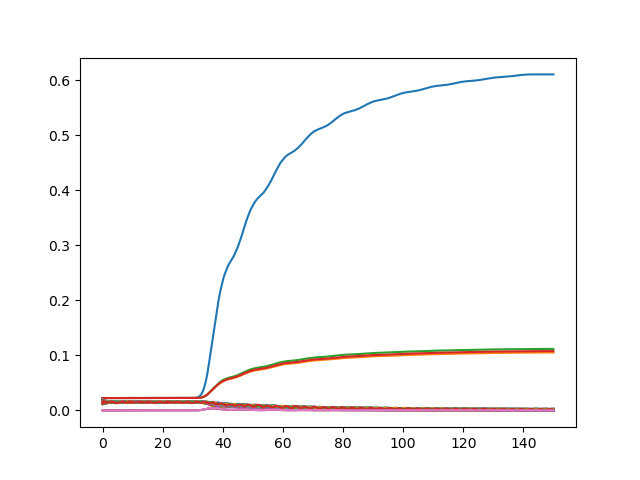

In [308]:
fig, ax = plt.subplots()
ax.plot(t_array*1e6, pop_results.T);

<IPython.core.display.Javascript object>


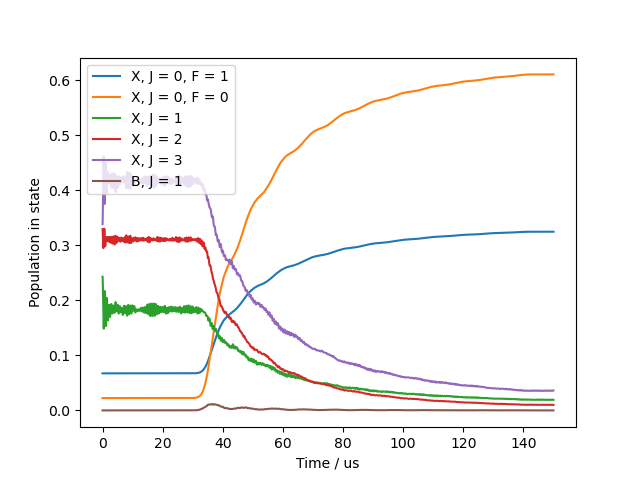

Text(0, 0.5, 'Population in state')

In [309]:
#Plot populations in different J
P0_triplet = np.sum(pop_results[1:4,:], axis = 0)
P0_singlet = np.sum(pop_results[0:1,:], axis = 0)
P1 = np.sum(pop_results[4:16,:], axis = 0)
P2 = np.sum(pop_results[16:36,:], axis = 0)
P3 = np.sum(pop_results[36:64,:], axis = 0)
PB1 = np.sum(pop_results[64:,:], axis = 0)

fig, ax = plt.subplots()
ax.plot(t_array*1e6, P0_triplet, label = 'X, J = 0, F = 1')
ax.plot(t_array*1e6, P0_singlet, label = 'X, J = 0, F = 0')
ax.plot(t_array*1e6, P1, label = 'X, J = 1')
ax.plot(t_array*1e6, P2, label = 'X, J = 2')
ax.plot(t_array*1e6, P3, label = 'X, J = 3')
ax.plot(t_array*1e6, PB1, label = 'B, J = 1')
ax.legend()
ax.set_xlabel("Time / us")
ax.set_ylabel("Population in state")

In [310]:
np.min(PB1)

0.0

In [311]:
P0_singlet[-1]/P0_triplet[-1]

1.8803771234852737

In [312]:
print(P0_triplet[-1])
print(P0_singlet[-1])
print(P1[-1])
print(P2[-1])
print(P3[-1])
print(PB1[-1])

0.3245010940152621
0.610184433732243
0.01907759177697586
0.009984700761505785
0.036250528496509025
1.3425814091892305e-11
